In [23]:
import torch
import pyro
import json
import matplotlib.pyplot as plt
import pyro.distributions as dist

from ESN import esnet
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

# Time-series forecasting

## Train ESN

Tr: 4882, Val: 1047, Te: 1047
train_embedding shape: (4882, 20)
Test MSE 0.193


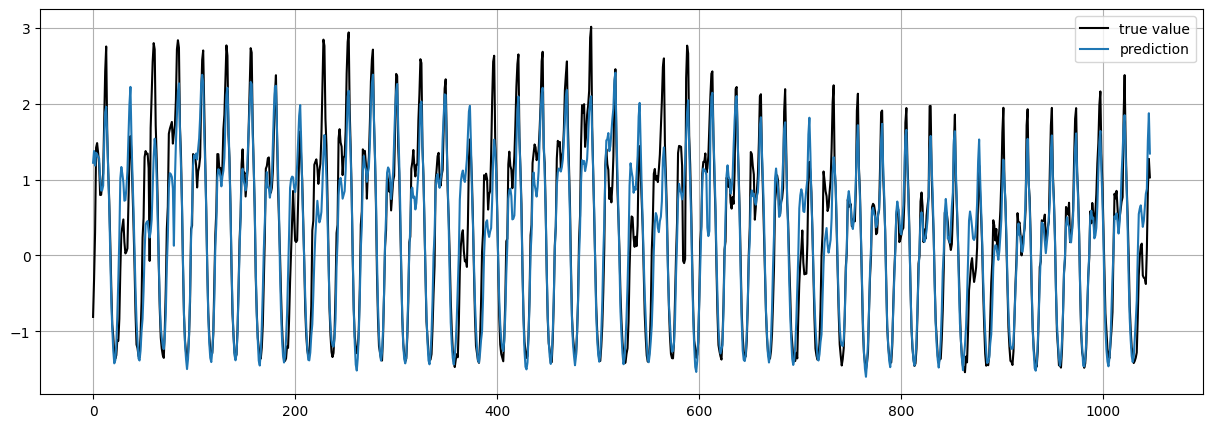

In [4]:
forecast_horizon = 24 

mat = loadmat('dataset/TS_Acea.mat')  # load mat-file
ACEA_data = mat['X'] # original resolution (1 = 10 mins)
ACEA_data = ACEA_data[::6] 
ACEA_data = ACEA_data[:7000] 

X = ACEA_data[:-forecast_horizon]
Y = ACEA_data[forecast_horizon:]

# Set ESN hyperparams
config = json.load(open('ESN/configs/ESN_hyperparams.json', 'r'))

Xtr, Ytr, Xval, Yval, Xte, Yte = esnet.generate_datasets(X, Y, test_percent = 0.15, val_percent = 0.15)
print("Tr: {:d}, Val: {:d}, Te: {:d}".format(Xtr.shape[0], Xval.shape[0], Xte.shape[0]))

# Train and compute predictions
Yte_pred, _, _, train_embedding, _, val_embedding, _, test_embedding = esnet.run_from_config_return_states(Xtr, Ytr, 
                                                                                                            Xte, Yte, 
                                                                                                            config, 
                                                                                                            validation=True,
                                                                                                            Xval=Xval,
                                                                                                            Yval=Yval)
print("train_embedding shape:", train_embedding.shape)
print('Test MSE {:.3f}'.format(mean_squared_error(Yte_pred, Yte)))

# Plot results
fig = plt.figure(figsize=(15,5))
plt.plot(Yte, label='true value', color='k')
plt.plot(Yte_pred, label='prediction')
plt.legend(loc='best', fontsize=10)
plt.grid()  
plt.show()

## Bayesian regression

In [ ]:
n_dims = train_embedding.shape[1]
# dtype = 'float32'
# train_embedding = train_embedding.astype(dtype)
train_embedding = torch.from_numpy(train_embedding)
# val_embedding = val_embedding.astype(dtype)
# test_embedding = test_embedding.astype(dtype)
# Ytr = Ytr.astype(dtype)
Ytr = torch.from_numpy(Ytr)

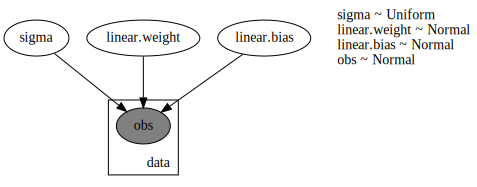

In [20]:
class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[torch.nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 10.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean # do I need the mean?

model = BayesianRegression(n_dims, 1)
pyro.render_model(model, model_args=(train_embedding, Ytr), render_distributions=True)

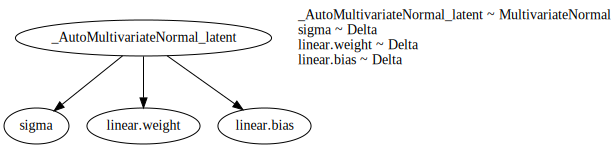

In [21]:
guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
pyro.render_model(guide, model_args=(train_embedding, Ytr), render_distributions=True)

In [22]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoMultivariateNormal.loc [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
AutoMultivariateNormal.scale [0.09999998 0.09999998 0.09999998 0.09999998 0.09999998 0.09999998
 0.09999998 0.09999998 0.09999998 0.09999998 0.09999998 0.09999998
 0.09999998 0.09999998 0.09999998 0.09999998 0.09999998 0.09999998
 0.09999998 0.09999998 0.09999998 0.09999998]
AutoMultivariateNormal.scale_tril [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.

In [24]:
adam = Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

num_iterations = 1500

# pyro.clear_param_store() # why do we need to clear the param store first?
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(train_embedding, Ytr)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / Ytr.shape[0]))

guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

ValueError: at site "obs", invalid log_prob shape
  Expected [4882], actual [4882, 4882]
  Try one of the following fixes:
  - enclose the batched tensor in a with pyro.plate(...): context
  - .to_event(...) the distribution being sampled
  - .permute() data dimensions

In [26]:
test = train_embedding[0]
guide(test)

{'sigma': tensor(5.2229, grad_fn=<ExpandBackward0>),
 'linear.weight': tensor([[-0.0954, -0.0544, -0.0381,  0.0450,  0.1175, -0.0519, -0.1038,  0.1366,
           0.0009, -0.0599, -0.2993,  0.0413,  0.0038, -0.0738, -0.0371,  0.0068,
          -0.0838, -0.1983, -0.1409, -0.0259]], grad_fn=<ExpandBackward0>),
 'linear.bias': tensor([0.0947], grad_fn=<ExpandBackward0>)}